# Assignment 4: Data Collection & Analysis (한국어 대학 강의 데이터 by AI Hub)

## 사전 데이터 준비 요약
이 Notebook에서 사용하는 `comp_sentences.csv`는 AI Hub "한국어 대학 강의 데이터" 라벨링 파일(TL.zip)에서  
**컴퓨터통신(eng/comp)** 카테고리만 추출하여 문장 단위 CSV로 변환해 둔 결과입니다.

사전 준비 과정은 아래와 같습니다.

1. TL.zip.part0, part1 병합 → TL.zip 생성  
2. zipfile 모듈로 TL.zip 내부의 `eng/comp/` 폴더만 선택적으로 추출  
3. 각 JSON에서 `06_transcription → 1_text` 필드만 수집  
4. (lecture_id, major, sentence) 형태로 CSV 생성 → `comp_sentences.csv`

본 Notebook에서는 **이 CSV를 기반으로 EDA를 수행합니다**.

(데이터 출처: https://www.aihub.or.kr/aihubdata/data/view.do?pageIndex=1&currMenu=115&topMenu=100&srchOptnCnd=OPTNCND001&searchKeyword=%ED%95%9C%EA%B5%AD%EC%96%B4+%EB%8C%80%ED%95%99+%EA%B0%95%EC%9D%98&srchDetailCnd=DETAILCND001&srchOrder=ORDER001&srchPagePer=20&aihubDataSe=data&dataSetSn=71627)

### 셀 1 — **드라이브 마운트 & 작업 폴더 이동**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/ML_Project
!ls -al

Mounted at /content/drive
/content/drive/MyDrive/ML_Project
total 2415589
-rw------- 1 root root   14931818 Nov 24 09:08 comp_sentences.csv
drwx------ 2 root root       4096 Nov 24 07:52 TL_comp
-rw------- 1 root root 1229313082 Nov 24 05:58 TL.zip
-rw------- 1 root root 1073741824 Nov 22 16:34 TL.zip.part0
-rw------- 1 root root  155571258 Nov 22 16:36 TL.zip.part1


### 셀 2 — **라이브러리 import**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

### 셀 3 — **데이터 로드**

In [ ]:
df = pd.read_csv("comp_sentences.csv")
df.head()

,lecture_id,major,sentence
0,C02199,comp,자연 (log)/(로그)를 취한 겁니다.
1,C02199,comp,이렇게 하면 이렇게 된다.
2,C02199,comp,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 다 죽이는 모든...
3,C02199,comp,통과시키는 걸 볼 수 있겠죠?
4,C02199,comp,이제 구성은 이렇게 되어 있고요.


### 셀 4 — 데이터 기본 정보

이 단계는 데이터 분석의 출발점입니다.
데이터셋의 크기(행·열 수), 컬럼 구성, 각 컬럼의 자료형을 확인함으로써:

- 이후 어떤 분석이 가능한지(텍스트, 범주형, 수치형 여부)

- 전처리 과정에서 타입 변환이 필요한지

- 전체 데이터 규모가 모델링과 실험 환경에 적합한지 (예: 너무 크면 샘플링 필요)

등을 미리 파악할 수 있습니다.

특히 텍스트 기반 모델을 만들기 전에
문장 수(행 수)가 충분한지, 불필요한 컬럼이 없는지 확인하는 필수적인 단계라고 생각합니다.

In [ ]:
print("데이터 크기:", df.shape)
print("\n컬럼:")
print(df.columns)

df.info()

데이터 크기: (122144, 3)

컬럼:
Index(['lecture_id', 'major', 'sentence'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122144 entries, 0 to 122143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lecture_id  122144 non-null  object
 1   major       122144 non-null  object
 2   sentence    122144 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


### 셀 5 — **결측치 / 중복 확인**

EDA의 기본 중 기본입니다.  
텍스트 데이터의 품질을 가장 먼저 평가해야 한다고 생각했습니다.

- 결측치 존재 → 텍스트가 비어 있는 문장이 포함됨 → 제거/보간 여부 결정 필요
- 중복 문장 많음 → 특정 문장이 모델에 과도하게 학습되어 bias 발생  
  특히 ‘요약 모델’에서 매우 치명적임

따라서 데이터 품질을 판단하는 핵심 지표이며,  
이후 전처리 전략(중복 제거 여부 등)에 직접적인 영향을 주는 분석입니다.

In [ ]:
print("결측치 개수:")
print(df.isna().sum())

print("\n중복 행 개수:", df.duplicated().sum())

결측치 개수:
lecture_id    0
major         0
sentence      0
dtype: int64

중복 행 개수: 2909


### 셀 6 — **문장 길이(문자 수) 통계**

문장 길이는 텍스트 모델에서 가장 중요한 기초 통계 중 하나입니다.

- 너무 긴 문장 → token explosion → 학습 불안정
- 너무 짧은 문장 → 정보량 부족 → 요약/분류 성능 저하

문장 길이 분포를 확인하면  
평균, 최소·최대, outlier 존재 여부 등을 파악할 수 있으며,  
"모델 입력 길이(max_len)를 어느 정도로 설정할지"  
결정하는 데 매우 중요한 기준이 됩니다.

즉, 이후 사용할 tokenizer와 모델 구조 선택의 핵심 근거입니다.

In [ ]:
df["sent_len"] = df["sentence"].astype(str).apply(len)

df["sent_len"].describe()

,sent_len
count,122144.000000
mean,46.917696
std,39.882380
min,1.000000
25%,20.000000
50%,36.000000
75%,62.000000
max,567.000000


### 셀 7 — **문장 길이 분포 시각화**

describe() 통계만으로 전체 분포의 형태를 파악하기 어렵습니다.  
히스토그램을 통해:

- 특정 길이에 데이터가 몰려 있는지(모달 분포)
- 극단적으로 긴/짧은 문장의 비율
- 분포가 한쪽으로 치우쳐 있는지 여부(편향 평가)

등을 직관적으로 확인할 수 있습니다.

이는 "긴 문장 자르기" 또는 "짧은 문장 제거"와 같은  
전처리 전략을 수립하는 데 필수적인 시각화입니다.

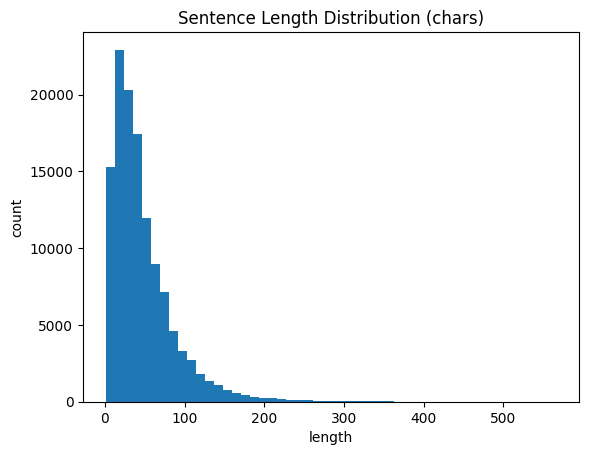

In [ ]:
plt.figure()
plt.hist(df["sent_len"], bins=50)
plt.title("Sentence Length Distribution (chars)")
plt.xlabel("length")
plt.ylabel("count")
plt.show()

### 셀 8 — **강의(lecture_id) 단위 통계**

lecture_id는 한 강의 전체를 의미하는 핵심 메타데이터입니다.  
이를 분석하는 이유는 다음과 같습니다.

- 강의별 데이터량이 고르게 분포하는지 확인
- 특정 강의가 지나치게 많은 문장을 포함하는지 확인
  → 데이터 편중(bias) 문제 발생 가능

또한 데이터 split 시  
"강의 단위로 나눌지" 혹은 "랜덤 샘플링할지" 결정하는 데 중요한 기준이 됩니다.

즉, 강의 단위 분석은 데이터의 구조적 특징을 이해하기 위한 핵심 단계입니다.

In [ ]:
n_lectures = df["lecture_id"].nunique()
print("강의(lecture_id) 개수:", n_lectures)

lecture_counts = df["lecture_id"].value_counts()
lecture_counts.head(10)

강의(lecture_id) 개수: 367


,count
lecture_id,
C02831,1433
C17831,1433
C02522,1312
C02224,1040
C02670,1001
C02977,989
C06502,899
C03088,873
C13604,864


### 셀 9 — **강의별 문장 수 분포 통계 및 시각화**

강의별 문장 수 전체 분포를 확인하여 데이터 구조적 특성을 분석합니다.

이 셀에서는 다음 정보를 산출합니다:

- 전체 강의의 문장 수 통계(describe)
- 문장 수가 가장 적은 강의 (lecture_id + count)
- 문장 수가 가장 많은 강의 (lecture_id + count)
- 하위 10개 강의 목록

이는 **데이터 불균형 정도를 정량적으로 파악**하는 데 매우 중요한 단계이며,  
향후 모델링에서 train/val split 전략, sampling 전략을 설계하는 근거로 사용됩니다.

전체 강의는 367개이며, 이 중 상위 강의들은 1,000문장 이상을 포함하는 경우, 하위 강의들은 100문장 이하만을 포함하는 경우도 있어, 강의 간 문장 수 차이가 크다는 점을 알 수 있습니다.

이러한 편중은 모델 학습 시 특정 강의 스타일로 과도하게 치우치는 bias를 유발할 수 있기 때문에  
추후 샘플링 비율 조정 또는 lecture_id 단위 split 전략을 설계하는 데 중요한 근거가 됩니다.

=== 강의별 문장 수 분포 통계 ===


,count
count,367.000000
mean,332.817439
std,211.746077
min,76.000000
25%,177.500000
50%,279.000000
75%,429.500000
max,1433.000000



=== 최소 문장 수 강의 ===
lecture_id: C13925, 문장 수: 76

=== 최대 문장 수 강의 ===
lecture_id: C02831, 문장 수: 1433

=== 하위 10개 강의 (문장 수 적은 순) ===


,count
lecture_id,
C13900,98
C08372,97
C08369,97
C08366,94
C13969,94
C13875,91
C02450,91
C08370,86
C13825,86


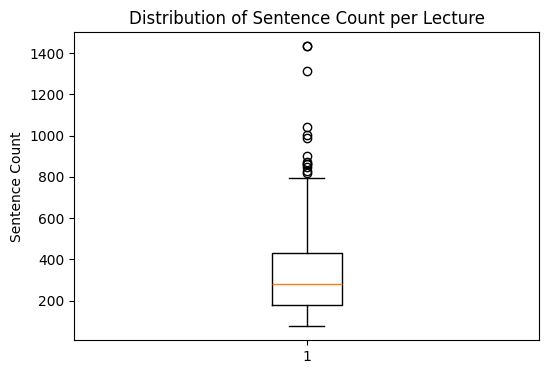

In [ ]:
print("=== 강의별 문장 수 분포 통계 ===")
display(lecture_counts.describe())

print("\n=== 최소 문장 수 강의 ===")
min_lecture_id = lecture_counts.idxmin()
min_count = lecture_counts.min()
print(f"lecture_id: {min_lecture_id}, 문장 수: {min_count}")

print("\n=== 최대 문장 수 강의 ===")
max_lecture_id = lecture_counts.idxmax()
max_count = lecture_counts.max()
print(f"lecture_id: {max_lecture_id}, 문장 수: {max_count}")

print("\n=== 하위 10개 강의 (문장 수 적은 순) ===")
display(lecture_counts.tail(10))

plt.figure(figsize=(6, 4))
plt.boxplot(lecture_counts.values)
plt.title("Distribution of Sentence Count per Lecture")
plt.ylabel("Sentence Count")
plt.show()

### 셀 10 — **가장 자주 등장하는 단어 Top20**

텍스트 데이터의 언어적 특성을 이해하기 위한 분석입니다.

- filler word("어", "자", "그래서")가 얼마나 많은지 확인  
  → stopword 전처리 필요 여부 판단
- 도메인 관련 키워드가 등장하는지 확인  
  (예: 신호, 주파수, 필터 등)

추가적으로  
TF-IDF · tokenizer · 단어 사전 생성 시 불용어 목록을 최적화할 수 있는 정보가 됩니다.

즉, 단순 단어 카운트가 아니라  
**전체 전처리 설계 방향을 결정하는 핵심 분석**입니다.

In [ ]:
def tokenize(s):
    return re.findall(r"[가-힣A-Za-z0-9]+", s)

words = []
for s in df["sentence"]:
    words += tokenize(str(s))

Counter(words).most_common(20)

[('이', 19574),
 ('그래서', 15183),
 ('이제', 14305),
 ('어', 13986),
 ('자', 12975),
 ('이렇게', 12867),
 ('그', 12844),
 ('우리가', 11534),
 ('수', 10540),
 ('이런', 10205),
 ('있는', 9668),
 ('뭐', 9353),
 ('하는', 5731),
 ('때', 5726),
 ('지금', 5606),
 ('그리고', 5503),
 ('있습니다', 5445),
 ('요', 5327),
 ('그러면', 5249),
 ('어떤', 4876)]

# **분석 요약 (Analysis Summary)**

본 Notebook에서는 AI Hub “한국어 대학 강의 데이터” 중  
**컴퓨터통신(eng/comp)** 카테고리의 전사 텍스트 122,144문장을 기반으로  
탐색적 데이터 분석(EDA)을 수행하였다.

---

## 1. 데이터 구성 특성

- 총 문장 수: **122,144개**
- 고유 lecture_id: **367개**
- 결측치: **0건**
- 중복 문장: **2,909건(약 2.3%)**

데이터는 `lecture_id`, `major`, `sentence` 세 개의 컬럼으로 구성되며  
텍스트 품질이 양호하고 결측이 없어 모델링에 그대로 활용 가능하다.  
중복 문장은 소수 존재하므로 학습 시 영향 최소화를 위해 deduplication 여부를 고려할 수 있다.

---

## 2. 문장 길이 분석

문장 길이 통계(df["sent_len"].describe()) 결과:

- 평균 길이: **46.9자**
- 중앙값: **36자**
- 25%~75% 구간: **20자 ~ 62자**
- 최단 문장: **1자**
- 최장 문장: **567자**

길이 분포는 **짧은 문장 쪽으로 치우친 left-skewed 형태**이며,  
길이가 극단적으로 긴 문장은 매우 적다.

**의미**  
- 대부분의 문장은 128~256 token 이하로 처리 가능  
- 극단적 long sentence는 truncate 기준이나 max_length 설정 시 고려 필요  
- 이후 모델 설계 시 token budget을 합리적으로 설정할 수 있는 근거 제공

---

## 3. 강의(lecture_id) 단위 문장 수 분석

전수 분석(lecture_counts.describe()) 결과:

- 강의 수: **367개**
- 평균 문장 수: **332.8**
- 중앙값: **279**
- 최소 문장 수: **76**
- 최대 문장 수: **1433**
- 하위 10개 강의: **76~98문장 수준**
- 상위 강의: **1000문장 이상 포함**

강의별 문장 수 편차가 매우 크며,
상위 강의들이 전체 데이터 비중의 상당 부분을 차지하는 **심한 불균형 구조**를 보인다.

**의미**  
- 모델 학습 시 특정 강의 스타일에 bias가 생길 위험  
- lecture_id 단위 stratified split 또는 sampling 전략 검토 필요  
- 극단적인 분포를 Boxplot으로 시각화하여 구조적으로 확인 가능

---

## 4. 자주 등장하는 단어 분석 (Top 20)

Counter 기반 단어 빈도 상위 단어는 대부분:

- “이”, “그래서”, “이제”, “어”, “자”, “이렇게”, “우리가” 등  
→ 강의 진행 중 반복되는 구어체 표현(filler words)

도메인 핵심 단어(“신호”, “주파수”, “필터” 등)는 상위권은 아니지만 충분히 등장함.

**의미**

- 구어체 filler 단어가 많아 stopword 목록을 커스터마이징할 필요가 있음  
- 도메인 용어가 존재하기 때문에 요약/핵심 포인트 추출 모델의 학습 데이터로 적절  
- token cleaning 또는 구어체 비중 조정 가능

---

## 5. 데이터 품질 이슈 정리

- **중복 문장 존재(2.3%)**  
  → deduplication 적용 시 모델 편향 완화 가능

- **강의 간 문장 수 불균형**  
  → sampling / stratified split 고려 필요

- **filler word 비중 높음**  
  → stopword 커스텀 또는 구어체 처리 필요

- **긴 문장 outlier 존재**  
  → truncate 기준 설정 및 max_length 조정 필요

---

# **결론**

해당 데이터셋은:

- 문장 수 충분  
- 결측치 없음  
- 도메인 용어 포함  
- 전처리 난이도 낮음  

이라는 점에서  
**강의 요약 / 핵심 포인트 추출 모델 학습에 매우 적합한 고품질 데이터**임을 확인하였다.

EDA를 통해 데이터 구조·분포·언어적 특징·불균형 요인을 명확히 파악하였으며,  
이는 Assignment 5에서 모델 설계(max_length, sampling, 전처리 규칙, split 기준)에 직접적으로 활용될 예정이다.